# Clairvoyante


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import time
import numpy as np
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import clairvoyante.utils as utils
import clairvoyante.clairvoyante as cv
import clairvoyante.param as param

## Load a trained model for Illumina sequencing data

In [3]:
# Load a trained model into memory
m = cv.Clairvoyante()
m.init()
m.restoreParameters("../trainedModels/illumina1/round2-less22-184885")

INFO:tensorflow:Restoring parameters from ../trainedModels/illumina1/round2-less22-184885


INFO:tensorflow:Restoring parameters from ../trainedModels/illumina1/round2-less22-184885


In [4]:
# Show the number of parameters of the model
r = tf.train.NewCheckpointReader("../trainedModels/illumina1/round2-less22-184885")
p = r.get_variable_to_shape_map()
tot = 0
for k, v in sorted(p.items(), key=lambda x: x[0]):
    if 'Momentum' not in k and\
       'global_step' not in k and\
       'Adam' not in k and\
       'power' not in k:
        tmp = np.prod(v)
        tot += tmp
        print >> sys.stderr, '%s: %s => %d' % (k, str(v), tmp)
print >> sys.stderr, 'Total number of parameters: %d' % tot

conv2d/bias: [16] => 16
conv2d/kernel: [1, 4, 4, 16] => 256
conv2d_1/bias: [32] => 32
conv2d_1/kernel: [2, 4, 16, 32] => 4096
conv2d_2/bias: [48] => 48
conv2d_2/kernel: [3, 4, 32, 48] => 18432
dense/bias: [336] => 336
dense/kernel: [4608, 336] => 1548288
dense_1/bias: [84] => 84
dense_1/kernel: [336, 84] => 28224
dense_2/bias: [4] => 4
dense_2/kernel: [84, 4] => 336
dense_3/bias: [5] => 5
dense_3/kernel: [84, 5] => 420
Total number of parameters: 1600577


In [17]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("../training/tensor_tmp",
                       "../training/var_chr22",
                       "../training/bed")

In [18]:
i = 0
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

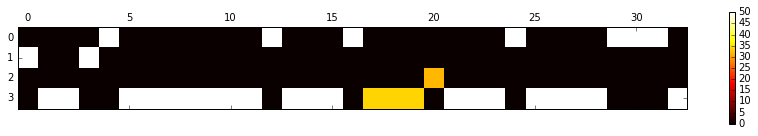

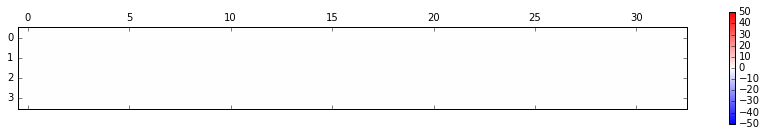

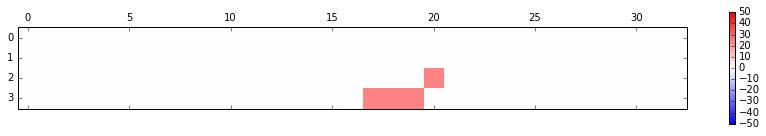

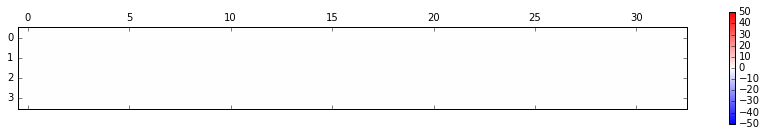

In [19]:
# Show how the four matrices are like
figure(figsize=(15, 2)); matshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.hot, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()

## Testing on the variants

In [ ]:
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases, ts = m.predict(XBatch)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, t = m.predict(XBatch)
    bases = np.append(bases, base, 0)
    ts = np.append(ts, t, 0)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
print >> sys.stderr, "Time elapsed: %.2f s" % (time.time() - predictStart)

ed = np.zeros( (5,5), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,4:]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1

for i in range(5):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(5)])

## Visualizing predictions

In [ ]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],ts[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)